In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, UpSampling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import cv2
import glob


In [ ]:
def build_generator():
    noise_shape = (100,)
    noise = Input(shape=noise_shape)
    
    model = Sequential()
    model.add(Dense(64 * 4 * 4,activation="relu", input_shape=noise_shape))
    model.add(Reshape((4,4,64)))
    model.add(BatchNormalization(momentum=0.8))
    
    for layer in [128,256,128,64]:
        model.add(UpSampling2D())
        model.add(Conv2D(layer, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(16, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    output_img = model(noise)

    return Model(noise, output_img)



In [ ]:
def build_discriminator():
    img = Input(shape=img_size)
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_size, padding="same")) #32,32
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    for layer in [64,128,128,128]:
        model.add(Conv2D(layer, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()
    validity = model(img)
    return Model(img, validity)

In [ ]:
def build_discriminator():
    img = Input(shape=img_size)
    model = Sequential()
    model.add(ResNet50(include_top=False, pooling='avg',input_shape=img_size, weights=None))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))    
    model.layers[0].trainable = False
    model.summary()
    #model.compile(loss='categorical_crossentropy',optimizer='adam')
    validity = model(img)
    return Model(img, validity)

In [ ]:
def build_discriminator():
    img = Input(shape=img_size)
    model=Sequential()
    model.add(LSTM(32,return_sequences=True,input_shape=img_size))
    model.add(LSTM(32,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(1, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer=RAdamOptimizer(learning_rate=1e-3))
    return model

In [ ]:
def build_model():
    # Build and compile the generator
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=RAdamOptimizer(learning_rate=1e-3))

    # The generator takes noise as input and generated imgs
    noise = Input(shape=(100,))
    generated_image = generator(noise)

    # Build and compile the discriminator
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', optimizer=RAdamOptimizer(learning_rate=1e-3), metrics=['accuracy'])
    discriminator.trainable = False

    # The valid takes generated images as input and determines validity
    validity = discriminator(generated_image)

    gan = Model(noise, validity)
    gan.compile(loss='binary_crossentropy', optimizer=RAdamOptimizer(learning_rate=1e-3))
    
    return discriminator,generator,gan



In [ ]:
def load_dataset(batch_size, image_shape, data_dir=None):
    sample_dim = (batch_size,) + image_shape
    sample = np.empty(sample_dim, dtype=np.float32)
    all_data_dirlist = list(glob.glob(data_dir))
    sample_imgs_paths = np.random.choice(all_data_dirlist,batch_size)
    for index,img_filename in enumerate(sample_imgs_paths):
        image = Image.open(img_filename)
        image = image.resize(image_shape[:-1])
        image = np.asarray(image)
        image = (image/127.5) -1 # normalizing data
        sample[index,...] = image
    return sample

def read_data():
    image_shape=(64,64,3)
    X_train = load_dataset(300, (64,64,3), "ex/*.jpeg")
    print('data loaded')
    return X_train

In [ ]:
def train(epochs, batch_size=128, save_interval=50):
    global discriminator, generator, gan
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):

        #  Train Discriminator
        real_ids = np.random.randint(0, X_train.shape[0], half_batch)
        real_imgs = X_train[real_ids]

        noise = np.random.normal(0, 1, (half_batch, 100))
        # Generate a half batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        real_loss = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        fake_loss = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(real_loss, fake_loss)

        #  Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [ ]:
def save_imgs(epoch):
    global discriminator, generator, gan
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[i*c+j])
            axs[i,j].axis('off')
            
    fig.savefig("results/animes_%d.jpeg" % epoch, dpi=600, bbox_inches='tight')
    plt.close()    
    generator.save("models/generator_%d.h5" % epoch)
    discriminator.save("models/discriminator_%d.h5" % epoch)


In [ ]:
img_rows = 64
img_cols = 64
channels = 3

img_size = (img_rows, img_cols,channels)


# In[218]:


X_train = read_data()


data loaded


Total number of images in the dataset 97


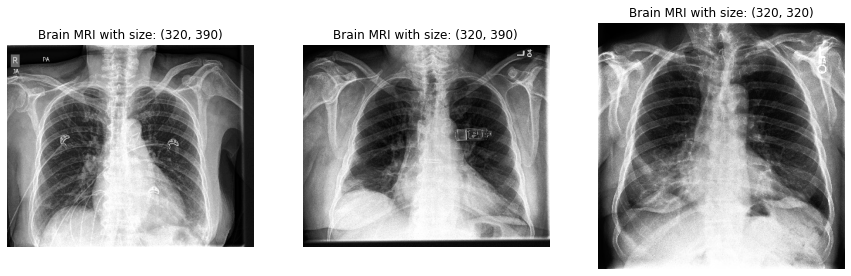

In [ ]:
import matplotlib.image as mpimg
import os
#path = 'models'
dataDir = 'iii'
files = glob.glob(os.path.join(dataDir, '*.jpg'))
print('Total number of images in the dataset', len(files))
#print(files)

fig, axes = plt.subplots(1, 3, figsize=(15, 10))
i = 0
for ax in axes:
    idx = np.random.randint(0, len(files))
    filename = files[idx]
    img = mpimg.imread(filename)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title('Brain MRI with size: {}'.format(img.shape))
    i += 1
    a=img.shape
   

In [ ]:

i=0
for a in range(len(files)):
    idx = np.random.randint(0, len(files))
    filename = files[idx]
   
    img = mpimg.imread(filename)
    
    a=img.shape
    if len(img.shape)==3:
        i=i+1
        print(filename)
        print(i)

data1/nejmc2001573_f1a.jpeg
1
data1/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
2
data1/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
3
data1/ryct.2020200034.fig5-day0.jpeg
4
data1/ryct.2020200034.fig5-day0.jpeg
5
data1/covid.jpeg
6
data1/ryct.2020200034.fig5-day0.jpeg
7
data1/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
8
data1/covid.jpeg
9
data1/nejmoa2001191_f5-PA.jpeg
10
data1/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
11
data1/nejmoa2001191_f5-PA.jpeg
12
data1/ryct.2020200034.fig5-day4.jpeg
13
data1/radiol.2020200490.fig3.jpeg
14
data1/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
15
data1/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
16
data1/nejmoa2001191_f3-PA.jpeg
17


In [ ]:
print(i)

8


In [ ]:
from PIL import Image 
from PIL import ImageFilter 
import os 
  
def main(): 
    # path of the folder containing the raw images 
    inPath ="home"
    i=0
    # path of the folder that will contain the modified image 
    outPath ="ex1"
    
    for imagePath in os.listdir(inPath): 
        
        #print(imagePath)
        inputPath = os.path.join(inPath, imagePath) 
        #print(imagePath)
        img = mpimg.imread(inputPath)
        if len(img.shape)!=3:
            img = Image.open(inputPath) 
            fullOutPath = os.path.join(outPath, 'covid_'+imagePath) 
            img.save(fullOutPath) 
            i=i+1
            print(fullOutPath)
            print(i)
  
        
  
        

In [ ]:
if __name__ == '__main__': 

    main()

ex/covid_nejmc2001573_f1b.jpeg
1
ex/covid_nejmc2001573_f1a.jpeg
2
ex/covid_nejmoa2001191_f5-PA.jpeg
3
ex/covid_nejmoa2001191_f3-PA.jpeg
4
ex/covid_nCoV-radiol.2020200269.fig1-day7.jpeg
5
ex/covid_radiopedia-covid-19-pneumonia-2.jpg
6
ex/covid_nejmoa2001191_f4.jpeg
7
ex/covid_ryct.2020200034.fig2.jpeg
8
ex/covid_radiol.2020200490.fig3.jpeg
9


In [ ]:
discriminator, generator, gan = build_model()


# In[ ]:




Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 1024)              103424    
_________________________________________________________________
reshape_11 (Reshape)         (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization_82 (Batc (None, 4, 4, 64)          256       
_________________________________________________________________
up_sampling2d_44 (UpSampling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
activation_66 (Activation)   (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 8, 8, 128)       

In [ ]:
from keras.applications.resnet50 import ResNet50

In [ ]:
from keras.layers import Dropout,Dense,TimeDistributed

In [ ]:
from keras_radam import RAdam

In [ ]:
from keras_radam.training import RAdamOptimizer


In [ ]:
!pip3 install keras-rectified-adam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=78ff8139c25381ee2657d781276c0ce3d783218fb972a1385fc024fba7018808
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam


In [ ]:
train(epochs=100000, batch_size=256, save_interval=200)

0 [D loss: 0.899730, acc.: 49.22%] [G loss: 0.783926]
1 [D loss: 0.862331, acc.: 53.52%] [G loss: 0.864426]
2 [D loss: 0.981940, acc.: 43.75%] [G loss: 0.953749]
3 [D loss: 0.919788, acc.: 50.78%] [G loss: 0.987641]
4 [D loss: 0.874914, acc.: 51.56%] [G loss: 1.008939]
5 [D loss: 0.835046, acc.: 53.52%] [G loss: 0.963106]
6 [D loss: 0.699875, acc.: 62.50%] [G loss: 1.033942]
7 [D loss: 0.697472, acc.: 64.84%] [G loss: 0.916199]
8 [D loss: 0.646849, acc.: 67.19%] [G loss: 0.954968]
9 [D loss: 0.611070, acc.: 67.58%] [G loss: 0.951318]
10 [D loss: 0.591093, acc.: 71.48%] [G loss: 0.911092]
11 [D loss: 0.551973, acc.: 73.83%] [G loss: 1.093802]
12 [D loss: 0.577200, acc.: 73.83%] [G loss: 1.116732]
13 [D loss: 0.485889, acc.: 73.44%] [G loss: 1.275868]
14 [D loss: 0.534129, acc.: 72.27%] [G loss: 1.137870]
15 [D loss: 0.509680, acc.: 75.39%] [G loss: 1.215971]
16 [D loss: 0.441477, acc.: 76.56%] [G loss: 1.356256]
17 [D loss: 0.433708, acc.: 80.86%] [G loss: 1.511613]
18 [D loss: 0.395602